OBJETIVO: poder conocer mejor a nuestros clientes para orientar nuestra actividad comercial.

# import libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA               
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

from numpy import random
random.seed(12)

# import data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_commercial_activity = pd.read_csv('/content/drive/MyDrive/T.I.C./Master Data Science/TFM/commercial_activity_df.csv', index_col = 0)

In [4]:
df_sociodemographic = pd.read_csv('/content/drive/MyDrive/T.I.C./Master Data Science/TFM/sociodemographic_df.csv', index_col = 0)

In [5]:
df_customer_products = pd.read_csv('/content/drive/MyDrive/T.I.C./Master Data Science/TFM/customer_products_df.csv', index_col = 0)

Como interesa tener el listado más grande de clientes, vamos a seleccionar la última partición (mayo 2019) para cada df.

In [6]:
# filtra los df por la partición de mayo 2019
df_commercial_activity = df_commercial_activity[df_commercial_activity['pk_partition'] == '2019-05']
df_sociodemographic = df_sociodemographic[df_sociodemographic['pk_partition'] == '2019-05']
df_customer_products = df_customer_products[df_customer_products['pk_partition'] == '2019-05']

In [7]:
df_commercial_activity.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
12715896,657826,2019-05,2015-05,013,1.0,02 - PARTICULARES
12715899,657817,2019-05,2019-05,NaN,0.0,NaN
12715982,657986,2019-05,2016-02,KAF,1.0,02 - PARTICULARES
12716026,657905,2019-05,2017-02,KAT,1.0,01 - TOP
12716082,657336,2019-05,2019-03,KAT,1.0,02 - PARTICULARES


In [8]:
df_sociodemographic.head()

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
12715896,657826,2019-05,ES,25.0,H,44,N,54493.38
12715899,657817,2019-05,ES,8.0,V,32,N,NaN
12715982,657986,2019-05,ES,41.0,H,39,N,100993.17
12716026,657905,2019-05,ES,28.0,H,85,N,154059.09
12716082,657336,2019-05,ES,28.0,V,38,N,NaN


In [9]:
df_customer_products.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
12715896,657826,2019-05,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
12715899,657817,2019-05,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
12715982,657986,2019-05,0,0,0,0,0,0,0,1,1.0,1.0,1,1,1,0,0
12716026,657905,2019-05,0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,1
12716082,657336,2019-05,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


Juntamos los 3 dfs (conservamos la columna pk_partition para crear la variable antiguedad posteriormente)

In [10]:
df =  df_commercial_activity.merge(df_sociodemographic, on=['pk_cid', 'pk_partition'], how='outer')

In [11]:
df =  df.merge(df_customer_products, on=['pk_cid', 'pk_partition'], how='outer')

In [12]:
df

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,657826,2019-05,2015-05,013,1.0,02 - PARTICULARES,ES,25.0,H,44,...,0,0,0,0.0,0.0,0,0,0,0,1
1,657817,2019-05,2019-05,NaN,0.0,NaN,ES,8.0,V,32,...,0,0,0,0.0,0.0,0,0,0,0,0
2,657986,2019-05,2016-02,KAF,1.0,02 - PARTICULARES,ES,41.0,H,39,...,0,0,1,1.0,1.0,1,1,1,0,0
3,657905,2019-05,2017-02,KAT,1.0,01 - TOP,ES,28.0,H,85,...,1,0,0,0.0,0.0,0,0,0,0,1
4,657336,2019-05,2019-03,KAT,1.0,02 - PARTICULARES,ES,28.0,V,38,...,0,0,0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442990,1166765,2019-05,2016-08,KHE,0.0,03 - UNIVERSITARIO,ES,50.0,V,22,...,0,0,0,0.0,0.0,0,0,0,0,1
442991,1166764,2019-05,2016-08,KHE,0.0,03 - UNIVERSITARIO,ES,26.0,V,23,...,0,0,0,0.0,0.0,0,0,0,0,1
442992,1166763,2019-05,2016-08,KHE,1.0,02 - PARTICULARES,ES,50.0,H,47,...,0,0,0,0.0,0.0,0,0,0,0,1
442993,1166789,2019-05,2016-08,KHE,0.0,03 - UNIVERSITARIO,ES,50.0,H,22,...,0,0,0,0.0,0.0,0,0,0,0,1


In [13]:
df_salario = df[['pk_cid', 'salary']]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442995 entries, 0 to 442994
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pk_cid              442995 non-null  int64  
 1   pk_partition        442995 non-null  object 
 2   entry_date          442995 non-null  object 
 3   entry_channel       438486 non-null  object 
 4   active_customer     442995 non-null  float64
 5   segment             438379 non-null  object 
 6   country_id          442995 non-null  object 
 7   region_code         442833 non-null  float64
 8   gender              442993 non-null  object 
 9   age                 442995 non-null  int64  
 10  deceased            442995 non-null  object 
 11  salary              293468 non-null  float64
 12  short_term_deposit  442995 non-null  int64  
 13  loans               442995 non-null  int64  
 14  mortgage            442995 non-null  int64  
 15  funds               442995 non-nul

# preprocessing

## gestión de variables

In [15]:
# elimina los clientes fallecidos (no son interesantes para incluir en un clustering con fines de marketing)
df = df[df['deceased']=='N']

# elimina la columna 'deceased'
df.drop('deceased', axis=1, inplace=True)

In [16]:
df.nunique()

pk_cid                442909
pk_partition               1
entry_date                53
entry_channel             65
active_customer            2
segment                    3
country_id                41
region_code               52
gender                     2
age                      104
salary                254452
short_term_deposit         2
loans                      2
mortgage                   2
funds                      2
securities                 2
long_term_deposit          2
em_account_pp              1
credit_card                2
payroll                    2
pension_plan               2
payroll_account            2
emc_account                2
debit_card                 2
em_account_p               2
em_acount                  2
dtype: int64

In [17]:
# elimina la columna 'em_account_pp' por tener solo un valor
df.drop('em_account_pp', axis=1, inplace=True)

## creación de variables

Se crea una variable 'alta_navidad' para los clientes que se dieron de alta entre los meses de octubre, noviembre, diciembre y enero

In [18]:
# cambia el formato de entry_date y pk_partition
df['entry_date'] = pd.to_datetime(df['entry_date'])
df['pk_partition'] = pd.to_datetime(df['pk_partition'])

In [19]:
df['mes_alta'] = df['entry_date'].dt.strftime('%m')
df['mes_alta'] = df['mes_alta'].astype(np.int8)
df['alta_navidad'] = np.where((df['mes_alta'] >= 10)|(df['mes_alta'] ==1), 1, 0)

In [20]:
df[['entry_date', 'alta_navidad']].head(20)

,entry_date,alta_navidad
0,2015-05-01,0
1,2019-05-01,0
2,2016-02-01,0
3,2017-02-01,0
4,2019-03-01,0
5,2017-06-01,0
6,2015-05-01,0
7,2017-05-01,0
8,2018-12-01,1
9,2016-05-01,0


In [21]:
# elimina la columna 'mes_alta'
df.drop('mes_alta', axis=1, inplace=True)

Se crea la variable 'antiguedad' en meses

In [22]:
# crea la variables antiguedad (en número de meses)
df['antiguedad'] = (df['pk_partition'] - df['entry_date']).astype('<m8[M]')

# elimina las columnas entry_date y pk_partition
df.drop(['entry_date', 'pk_partition'], axis=1, inplace=True)

In [23]:
df

,pk_cid,entry_channel,active_customer,segment,country_id,region_code,gender,age,salary,short_term_deposit,...,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,alta_navidad,antiguedad
0,657826,013,1.0,02 - PARTICULARES,ES,25.0,H,44,54493.38,0,...,0,0.0,0.0,0,0,0,0,1,0,48.0
1,657817,NaN,0.0,NaN,ES,8.0,V,32,NaN,0,...,0,0.0,0.0,0,0,0,0,0,0,0.0
2,657986,KAF,1.0,02 - PARTICULARES,ES,41.0,H,39,100993.17,0,...,1,1.0,1.0,1,1,1,0,0,0,38.0
3,657905,KAT,1.0,01 - TOP,ES,28.0,H,85,154059.09,0,...,0,0.0,0.0,0,0,0,0,1,0,26.0
4,657336,KAT,1.0,02 - PARTICULARES,ES,28.0,V,38,NaN,0,...,0,0.0,0.0,0,0,0,0,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442990,1166765,KHE,0.0,03 - UNIVERSITARIO,ES,50.0,V,22,43912.17,0,...,0,0.0,0.0,0,0,0,0,1,0,32.0
442991,1166764,KHE,0.0,03 - UNIVERSITARIO,ES,26.0,V,23,23334.99,0,...,0,0.0,0.0,0,0,0,0,1,0,32.0
442992,1166763,KHE,1.0,02 - PARTICULARES,ES,50.0,H,47,NaN,0,...,0,0.0,0.0,0,0,0,0,1,0,32.0
442993,1166789,KHE,0.0,03 - UNIVERSITARIO,ES,50.0,H,22,199592.82,0,...,0,0.0,0.0,0,0,0,0,1,0,32.0


## feature engineering

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442909 entries, 0 to 442994
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pk_cid              442909 non-null  int64  
 1   entry_channel       438400 non-null  object 
 2   active_customer     442909 non-null  float64
 3   segment             438293 non-null  object 
 4   country_id          442909 non-null  object 
 5   region_code         442748 non-null  float64
 6   gender              442907 non-null  object 
 7   age                 442909 non-null  int64  
 8   salary              293396 non-null  float64
 9   short_term_deposit  442909 non-null  int64  
 10  loans               442909 non-null  int64  
 11  mortgage            442909 non-null  int64  
 12  funds               442909 non-null  int64  
 13  securities          442909 non-null  int64  
 14  long_term_deposit   442909 non-null  int64  
 15  credit_card         442909 non-nul

### entry_channel

In [25]:
df['entry_channel'].value_counts()

KHE    194723
KHQ     74967
KFC     58935
KHM     29903
KAT     26248
        ...  
KGX         1
004         1
KBE         1
KAI         1
KGC         1
Name: entry_channel, Length: 65, dtype: int64

La variable entry_channel tiene 65 etiquetas diferentes. Se guardan las que suman el 80% de los valores con su nombre original. El resto se agrupan con el nombre 'otro'.

In [26]:
(df['entry_channel'].value_counts()/len(df)).cumsum().head(10)

KHE    0.439646
KHQ    0.608906
KFC    0.741970
KHM    0.809485
KAT    0.868747
KHK    0.905204
KHN    0.941356
RED    0.952896
KFA    0.964063
KHD    0.974950
Name: entry_channel, dtype: float64

In [27]:
# seleciona los 4 primeros items (suman el 80%)
top_4_entry_channel = df['entry_channel'].value_counts().head(4).index

In [28]:
top_4_entry_channel

Index(['KHE', 'KHQ', 'KFC', 'KHM'], dtype='object')

In [29]:
# modifica el entry_channel para guardar solo los 4 más frecuentes. El resto se agrupará en la etiqueta 'otro'
df.loc[df['entry_channel'].isin(top_4_entry_channel)==False, 'entry_channel'] = 'otro'

In [30]:
df['entry_channel'].unique()

array(['otro', 'KFC', 'KHM', 'KHE', 'KHQ'], dtype=object)

### country_id

In [31]:
df.shape

(442909, 25)

In [32]:
df['country_id'].value_counts()

ES    442748
GB        32
US        18
FR        15
CH        13
DE        13
BE         7
BR         6
VE         5
MX         5
IE         4
PL         4
AR         4
AT         3
IT         3
CL         2
SE         2
MA         2
MR         1
CN         1
PT         1
CA         1
QA         1
DO         1
LU         1
RO         1
NO         1
SN         1
CM         1
DZ         1
GT         1
GA         1
CO         1
RU         1
SA         1
ET         1
HU         1
PE         1
JM         1
CI         1
DJ         1
Name: country_id, dtype: int64

In [33]:
# elimina la variable countr_id por tener muy poca varianza (99.96% de los registros son España)
df.drop('country_id', axis=1, inplace=True)

### region_code

Después de muchos intentos de agrupar los clientes por región (metropolis, rural, top 10 ciudades, comunidades), he podido comprobar que esta variable no enriquece el modelo. Se generan clústers que solo tienen la región como diferencia: ejemplo, un clúster para Albacete.</br>
Tomo la decisión de eliminar la variable.

In [34]:
# elimina la columna region_code
df.drop('region_code', axis=1, inplace=True)

### productos

Me quedo con todos los productos tal como vienen: se eliminarán los productos con poca varianza después del one hot encoding

## gestión de los nulos

In [35]:
df.isnull().sum()

pk_cid                     0
entry_channel              0
active_customer            0
segment                 4616
gender                     2
age                        0
salary                149513
short_term_deposit         0
loans                      0
mortgage                   0
funds                      0
securities                 0
long_term_deposit          0
credit_card                0
payroll                    0
pension_plan               0
payroll_account            0
emc_account                0
debit_card                 0
em_account_p               0
em_acount                  0
alta_navidad               0
antiguedad                 0
dtype: int64

In [36]:
round(df.isnull().sum()/len(df)*100, 1)

pk_cid                 0.0
entry_channel          0.0
active_customer        0.0
segment                1.0
gender                 0.0
age                    0.0
salary                33.8
short_term_deposit     0.0
loans                  0.0
mortgage               0.0
funds                  0.0
securities             0.0
long_term_deposit      0.0
credit_card            0.0
payroll                0.0
pension_plan           0.0
payroll_account        0.0
emc_account            0.0
debit_card             0.0
em_account_p           0.0
em_acount              0.0
alta_navidad           0.0
antiguedad             0.0
dtype: float64

In [37]:
# sortea los datos por antiguedad
df.sort_values('antiguedad', inplace=True)

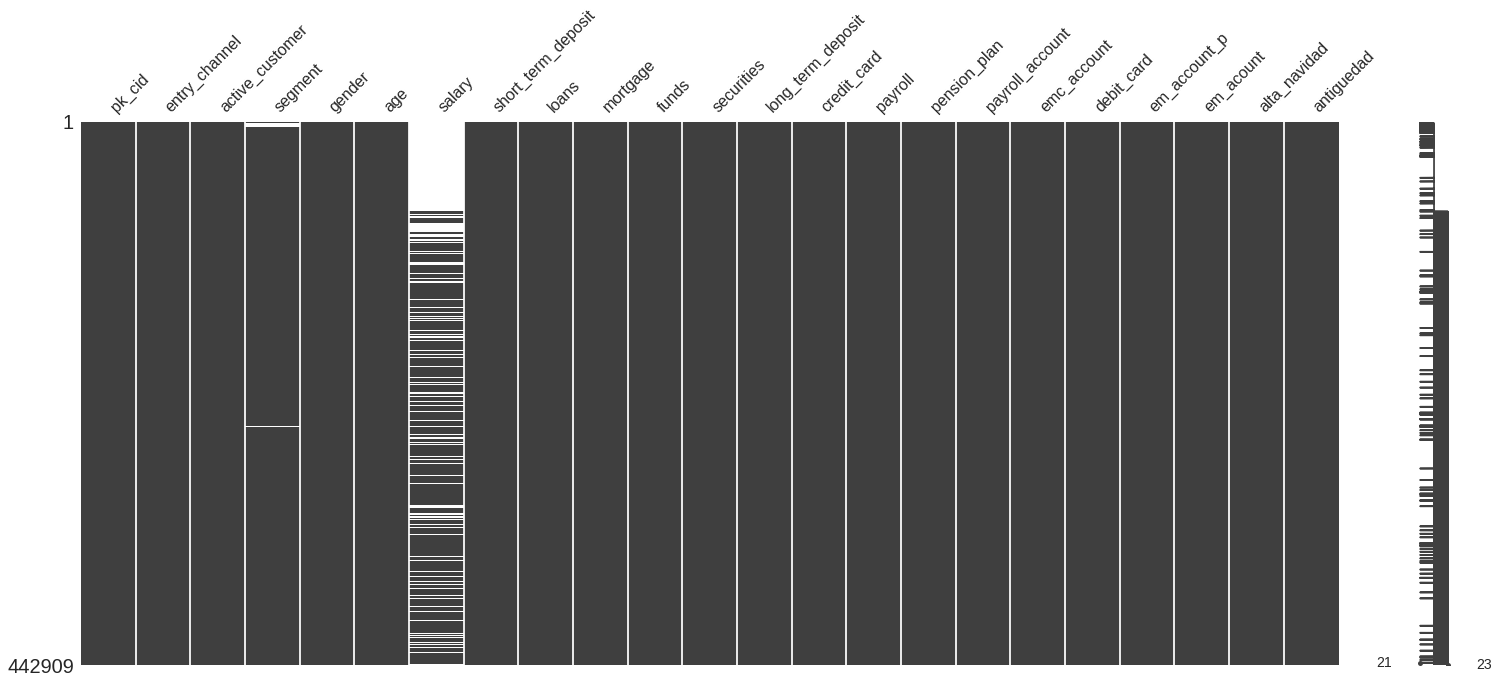

In [38]:
# visualiza la repartición de los nulos
msno.matrix(df)
plt.show()

Se puede ver que los nulos de la variable salary se concentran la mayoria en los clientes de poco antigüedad. No tienen introducidos el salario. Quitar los items con nulo en salario significa eliminar todos los clientes con una antigüedad menor o igual a 6 meses. Con pruebas anteriores he podido ver que la variable salary no tiene una distribución diferente en los clústers creados. Tampoco separando el dataset en 2, los nuevos sin salary y los antiguos con salary: se repiten los clústers.

In [39]:
df['salary'].describe()

count    2.933960e+05
mean     1.164622e+05
std      2.073196e+05
min      1.202730e+03
25%      6.153750e+04
50%      8.879661e+04
75%      1.321403e+05
max      2.889440e+07
Name: salary, dtype: float64

La media del salario es 116.000€, el mínimo es 1.200€, el máximo es casí 29.000.000€ y la desviación estandár es más de 200.000€. Hay tanta desviación en la variable que no tiene sentido afectar ningún valor, ni siquiera la mediana. Sesgaría mucho la distribución de la variable. 

Decido eliminar la variable salary.

In [40]:
df.drop('salary', axis=1, inplace=True)

In [41]:
# elimina los registros residuales con algún nulo
df.dropna(inplace=True)

In [42]:
df.shape

(438291, 22)

In [43]:
df.isna().sum().sum()

0

## pk_cid

In [44]:
# guarda los pk_cid antes de eliminarlos
pk_cid = df['pk_cid']

In [45]:
# elimina la columna 'pk_cid'
df.drop('pk_cid', axis=1, inplace=True)

## outliers

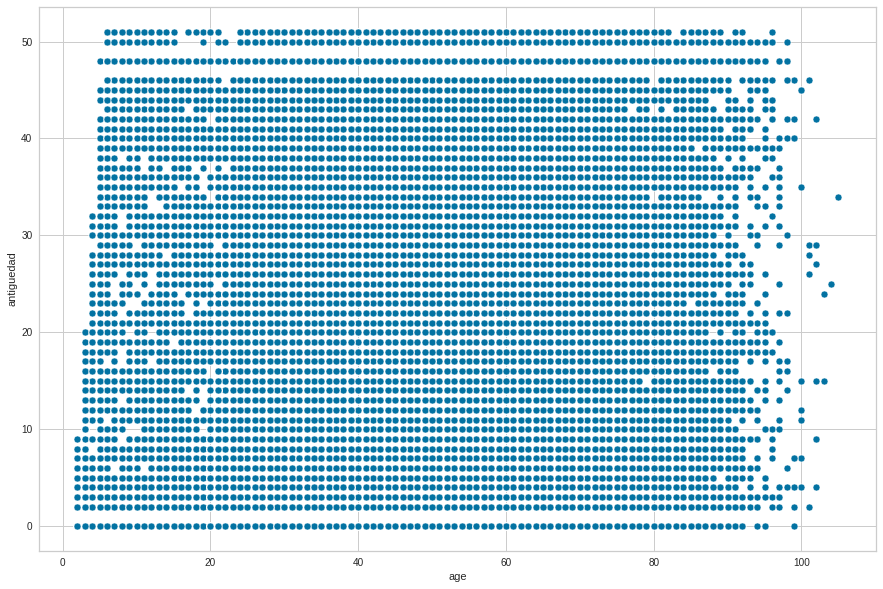

In [46]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='age', y='antiguedad')
plt.show()

No se observan outliers en antigüedad ni age en el dataset completo

## correlación

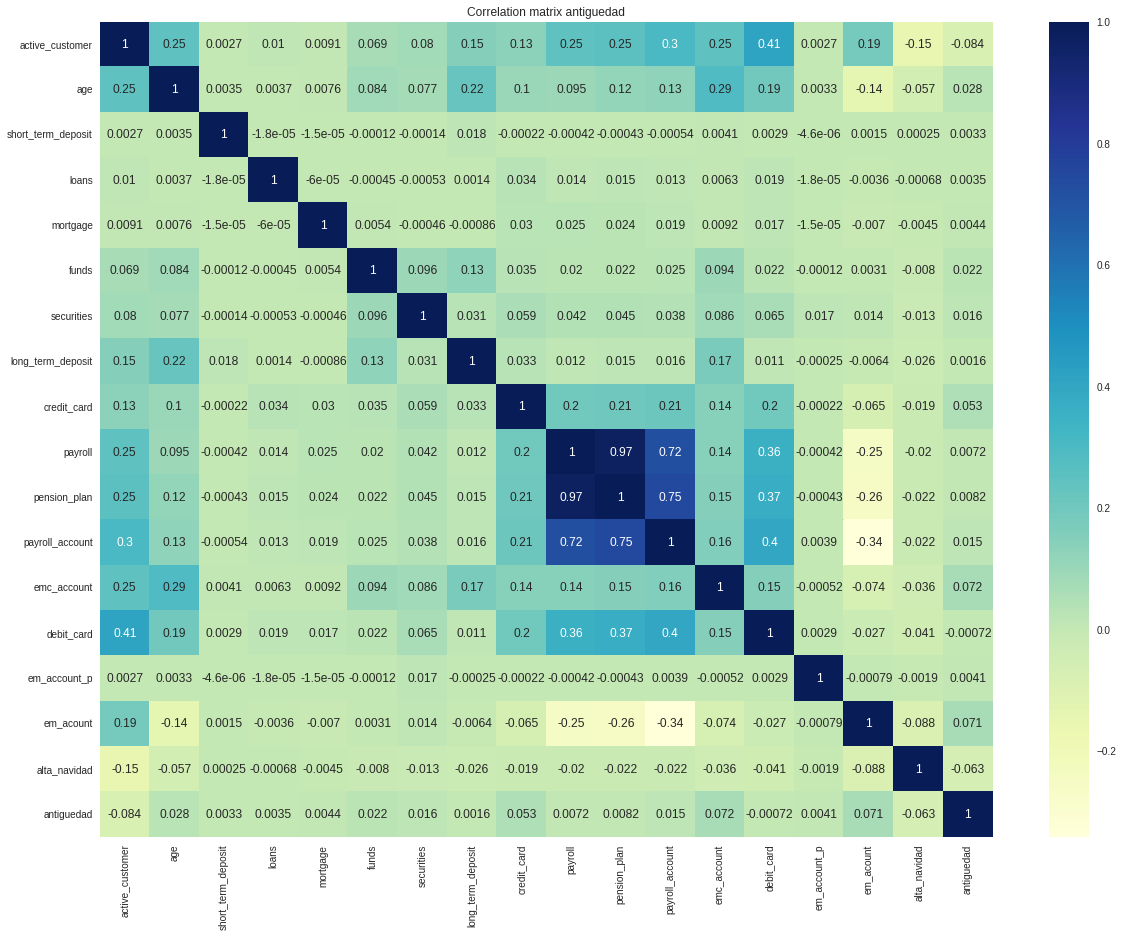

In [47]:
plt.rcParams['figure.figsize'] = 20, 15
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu").set_title(('Correlation matrix {}'.format(df.columns[-1])))
plt.show()

In [48]:
# procedo a quitar la variable payroll por ser demasiado correlacionada con pension_plan. Me quedo con pension_plan por ser el producto que genera mayor margen neto.
df.drop('payroll', axis=1, inplace=True)

## one hot encoding

In [49]:
df_one_hot = pd.get_dummies(df)

In [50]:
df_one_hot.columns

Index(['active_customer', 'age', 'short_term_deposit', 'loans', 'mortgage',
       'funds', 'securities', 'long_term_deposit', 'credit_card',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_account_p', 'em_acount', 'alta_navidad', 'antiguedad',
       'entry_channel_KFC', 'entry_channel_KHE', 'entry_channel_KHM',
       'entry_channel_KHQ', 'entry_channel_otro', 'segment_01 - TOP',
       'segment_02 - PARTICULARES', 'segment_03 - UNIVERSITARIO', 'gender_H',
       'gender_V'],
      dtype='object')

In [51]:
# elimina la columna 'gender_H' y me quedo solo con la columna 'gender_V'
df_one_hot.drop('gender_H', axis=1, inplace=True)

## variables con poca varianza

In [52]:
#Elimina columnas donde el 98.5% de los valores son iguales
vt = VarianceThreshold(threshold = 0.015) 
vt.fit(df_one_hot)

cols_lowvar = df_one_hot.columns[vt.get_support()==False]

In [53]:
cols_lowvar

Index(['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'credit_card', 'em_account_p'],
      dtype='object')

In [54]:
df_one_hot.drop(columns=cols_lowvar,inplace=True)

## estandarización

In [55]:
#Estandariza los datos
scaler = StandardScaler()
scaler.fit(df_one_hot)
df_scaled = pd.DataFrame(scaler.transform(df_one_hot),columns= df_one_hot.columns )

In [56]:
df_scaled

,active_customer,age,pension_plan,payroll_account,emc_account,debit_card,em_acount,alta_navidad,antiguedad,entry_channel_KFC,entry_channel_KHE,entry_channel_KHM,entry_channel_KHQ,entry_channel_otro,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,gender_V
0,1.256233,1.619326,-0.202886,-0.253684,-0.244473,-0.330639,0.697838,-0.887888,-1.639472,-0.394005,-0.894126,3.697010,-0.454243,-0.471888,-0.128952,1.408476,-1.358291,1.030060
1,1.256233,0.057975,-0.202886,-0.253684,-0.244473,-0.330639,0.697838,-0.887888,-1.639472,-0.394005,-0.894126,-0.270489,-0.454243,2.119147,-0.128952,1.408476,-1.358291,-0.970817
2,-0.796031,2.687620,-0.202886,-0.253684,-0.244473,-0.330639,-1.432998,-0.887888,-1.639472,-0.394005,-0.894126,-0.270489,-0.454243,2.119147,-0.128952,1.408476,-1.358291,1.030060
3,1.256233,0.551033,-0.202886,-0.253684,-0.244473,-0.330639,0.697838,-0.887888,-1.639472,-0.394005,-0.894126,3.697010,-0.454243,-0.471888,-0.128952,1.408476,-1.358291,1.030060
4,1.256233,-0.270731,-0.202886,3.941911,-0.244473,-0.330639,-1.432998,-0.887888,-1.639472,-0.394005,-0.894126,-0.270489,-0.454243,2.119147,-0.128952,1.408476,-1.358291,-0.970817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438286,-0.796031,0.057975,-0.202886,-0.253684,4.090434,-0.330639,-1.432998,1.126269,1.975816,2.538041,-0.894126,-0.270489,-0.454243,-0.471888,-0.128952,-0.709987,0.736219,-0.970817
438287,1.256233,-0.517260,-0.202886,-0.253684,4.090434,-0.330639,0.697838,1.126269,1.975816,2.538041,-0.894126,-0.270489,-0.454243,-0.471888,-0.128952,-0.709987,0.736219,1.030060
438288,1.256233,1.208444,-0.202886,-0.253684,-0.244473,-0.330639,0.697838,1.126269,1.975816,-0.394005,-0.894126,-0.270489,-0.454243,2.119147,-0.128952,1.408476,-1.358291,1.030060
438289,1.256233,3.920266,-0.202886,-0.253684,4.090434,-0.330639,0.697838,1.126269,1.975816,-0.394005,-0.894126,-0.270489,-0.454243,2.119147,7.754804,-0.709987,-1.358291,-0.970817


# PCA


## intrinsic dimension

In [57]:
pca = PCA()
pca.fit(df_scaled)

PCA()

In [58]:
pca.n_components_

18

In [59]:
pca.feature_names_in_

array(['active_customer', 'age', 'pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_acount', 'alta_navidad',
       'antiguedad', 'entry_channel_KFC', 'entry_channel_KHE',
       'entry_channel_KHM', 'entry_channel_KHQ', 'entry_channel_otro',
       'segment_01 - TOP', 'segment_02 - PARTICULARES',
       'segment_03 - UNIVERSITARIO', 'gender_V'], dtype=object)

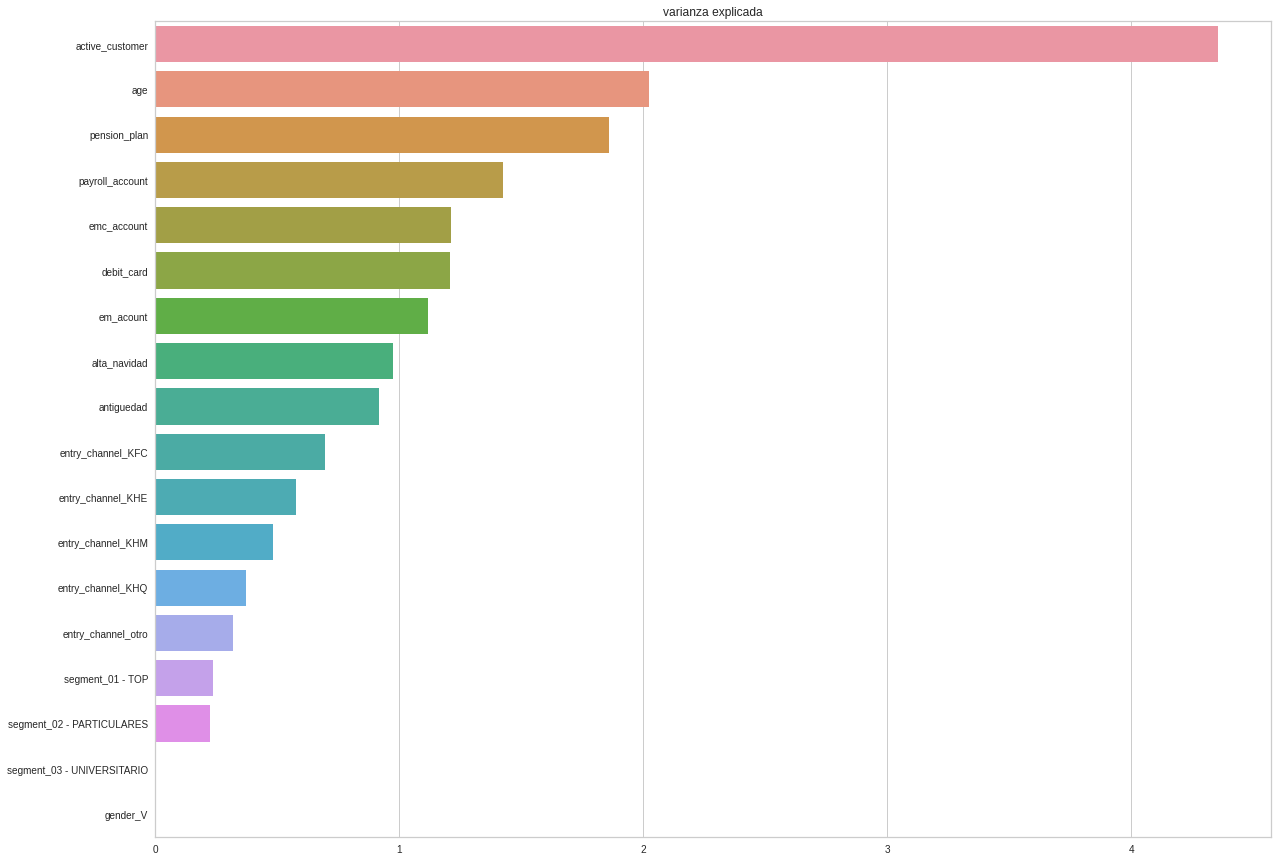

In [60]:
sns.barplot(y=pca.feature_names_in_, x=pca.explained_variance_)
plt.title('varianza explicada')
plt.show()

# clustering

## metodo del codo

Cantidad de clusters/distorsion:


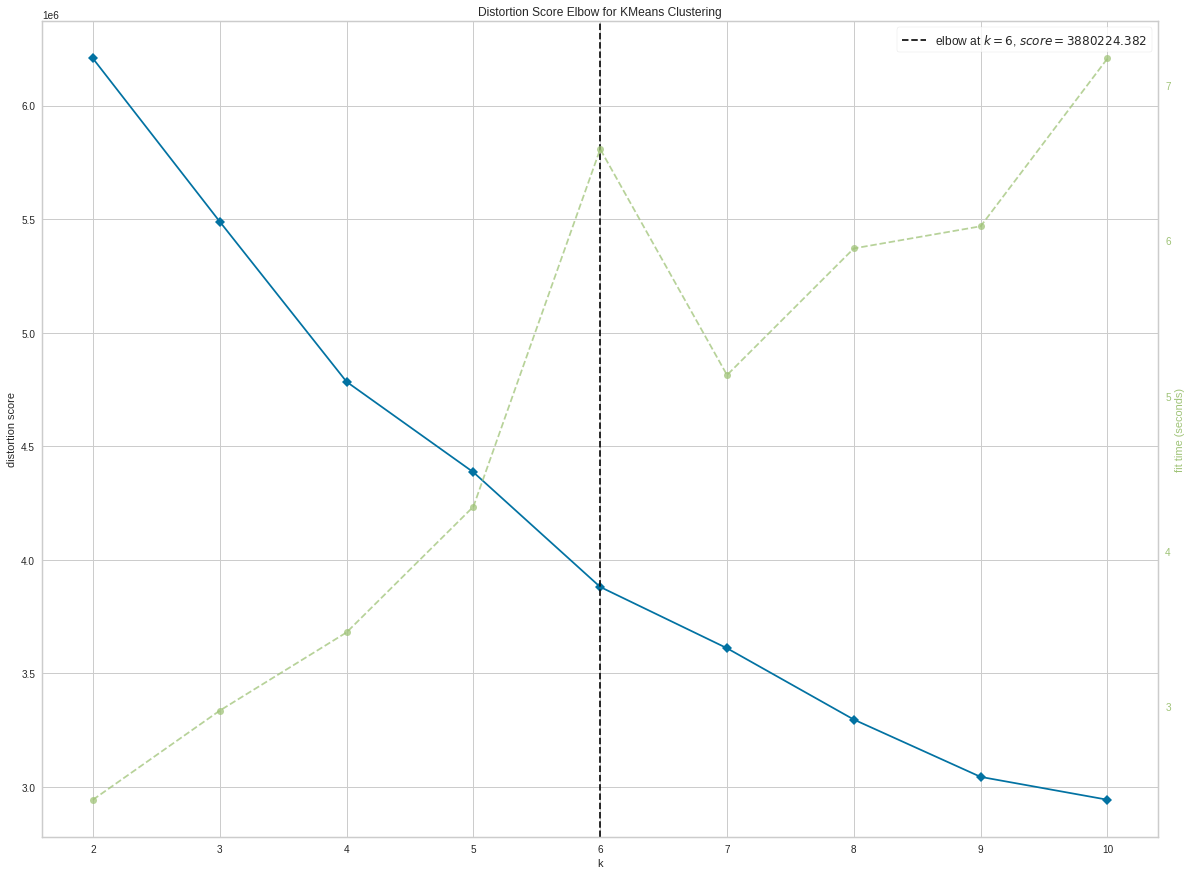

In [61]:
# Método del codo para ver cuantos clusters pedirle al algoritmo (usa la libreria yellowbrick.cluster).
print('Cantidad de clusters/distorsion:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_scaled)
Elbow_M.show()

Se ha encontrado un codo a 6 clústers.

In [62]:
df_scaled

,active_customer,age,pension_plan,payroll_account,emc_account,debit_card,em_acount,alta_navidad,antiguedad,entry_channel_KFC,entry_channel_KHE,entry_channel_KHM,entry_channel_KHQ,entry_channel_otro,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,gender_V
0,1.256233,1.619326,-0.202886,-0.253684,-0.244473,-0.330639,0.697838,-0.887888,-1.639472,-0.394005,-0.894126,3.697010,-0.454243,-0.471888,-0.128952,1.408476,-1.358291,1.030060
1,1.256233,0.057975,-0.202886,-0.253684,-0.244473,-0.330639,0.697838,-0.887888,-1.639472,-0.394005,-0.894126,-0.270489,-0.454243,2.119147,-0.128952,1.408476,-1.358291,-0.970817
2,-0.796031,2.687620,-0.202886,-0.253684,-0.244473,-0.330639,-1.432998,-0.887888,-1.639472,-0.394005,-0.894126,-0.270489,-0.454243,2.119147,-0.128952,1.408476,-1.358291,1.030060
3,1.256233,0.551033,-0.202886,-0.253684,-0.244473,-0.330639,0.697838,-0.887888,-1.639472,-0.394005,-0.894126,3.697010,-0.454243,-0.471888,-0.128952,1.408476,-1.358291,1.030060
4,1.256233,-0.270731,-0.202886,3.941911,-0.244473,-0.330639,-1.432998,-0.887888,-1.639472,-0.394005,-0.894126,-0.270489,-0.454243,2.119147,-0.128952,1.408476,-1.358291,-0.970817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438286,-0.796031,0.057975,-0.202886,-0.253684,4.090434,-0.330639,-1.432998,1.126269,1.975816,2.538041,-0.894126,-0.270489,-0.454243,-0.471888,-0.128952,-0.709987,0.736219,-0.970817
438287,1.256233,-0.517260,-0.202886,-0.253684,4.090434,-0.330639,0.697838,1.126269,1.975816,2.538041,-0.894126,-0.270489,-0.454243,-0.471888,-0.128952,-0.709987,0.736219,1.030060
438288,1.256233,1.208444,-0.202886,-0.253684,-0.244473,-0.330639,0.697838,1.126269,1.975816,-0.394005,-0.894126,-0.270489,-0.454243,2.119147,-0.128952,1.408476,-1.358291,1.030060
438289,1.256233,3.920266,-0.202886,-0.253684,4.090434,-0.330639,0.697838,1.126269,1.975816,-0.394005,-0.894126,-0.270489,-0.454243,2.119147,7.754804,-0.709987,-1.358291,-0.970817


## kmeans

In [63]:
# Initiating the Agglomerative Clustering model 
kmeans = KMeans(n_clusters=6, random_state=42)
pred_kmeans = kmeans.fit_predict(df_scaled)

# crea una copia del df original
df_kmeans = df.copy()

# añade la etiqueta de clusters al dataset original para poder analizarlo
df_kmeans["cluster"]= pred_kmeans

In [64]:
pred_kmeans

array([1, 1, 1, ..., 1, 4, 5], dtype=int32)

In [65]:
df_kmeans.columns

Index(['entry_channel', 'active_customer', 'segment', 'gender', 'age',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'credit_card', 'pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_account_p', 'em_acount',
       'alta_navidad', 'antiguedad', 'cluster'],
      dtype='object')

In [66]:
# elimina las variables con poca varianza del dataset para simplificar el analisis
df_kmeans.drop(cols_lowvar, axis=1, inplace=True)

In [67]:
df_kmeans

,entry_channel,active_customer,segment,gender,age,pension_plan,payroll_account,emc_account,debit_card,em_acount,alta_navidad,antiguedad,cluster
161210,KHM,1.0,02 - PARTICULARES,V,50,0.0,0,0,0,1,0,0.0,1
161211,otro,1.0,02 - PARTICULARES,H,31,0.0,0,0,0,1,0,0.0,1
161212,otro,0.0,02 - PARTICULARES,V,63,0.0,0,0,0,0,0,0.0,1
161213,KHM,1.0,02 - PARTICULARES,V,37,0.0,0,0,0,1,0,0.0,1
161214,otro,1.0,02 - PARTICULARES,H,27,0.0,1,0,0,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296670,KFC,0.0,03 - UNIVERSITARIO,H,31,0.0,0,1,0,0,1,51.0,5
296671,KFC,1.0,03 - UNIVERSITARIO,V,24,0.0,0,1,0,1,1,51.0,5
296672,otro,1.0,02 - PARTICULARES,V,45,0.0,0,0,0,1,1,51.0,1
296619,otro,1.0,01 - TOP,H,78,0.0,0,1,0,1,1,51.0,4


In [68]:
# se vuelve a introducir la variable salary
df_kmeans['pk_cid'] = pk_cid

In [69]:
df_kmeans = df_kmeans.merge(df_salario, on='pk_cid', how='left')

In [70]:
df_kmeans

,entry_channel,active_customer,segment,gender,age,pension_plan,payroll_account,emc_account,debit_card,em_acount,alta_navidad,antiguedad,cluster,pk_cid,salary
0,KHM,1.0,02 - PARTICULARES,V,50,0.0,0,0,0,1,0,0.0,1,1545623,NaN
1,otro,1.0,02 - PARTICULARES,H,31,0.0,0,0,0,1,0,0.0,1,1545622,NaN
2,otro,0.0,02 - PARTICULARES,V,63,0.0,0,0,0,0,0,0.0,1,1545621,NaN
3,KHM,1.0,02 - PARTICULARES,V,37,0.0,0,0,0,1,0,0.0,1,1545620,NaN
4,otro,1.0,02 - PARTICULARES,H,27,0.0,1,0,0,0,0,0.0,1,1545618,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438286,KFC,0.0,03 - UNIVERSITARIO,H,31,0.0,0,1,0,0,1,51.0,5,1002348,58658.58
438287,KFC,1.0,03 - UNIVERSITARIO,V,24,0.0,0,1,0,1,1,51.0,5,1002347,174851.55
438288,otro,1.0,02 - PARTICULARES,V,45,0.0,0,0,0,1,1,51.0,1,1002345,53485.74
438289,otro,1.0,01 - TOP,H,78,0.0,0,1,0,1,1,51.0,4,1002061,220995.78


# perfilado

## EDA

### distribución de los clientes en los clústers

In [71]:
def add_value_labels(ax, spacing=5):
    """añade los valores del countplot
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va="bottom"

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va="top"

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha="center",                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

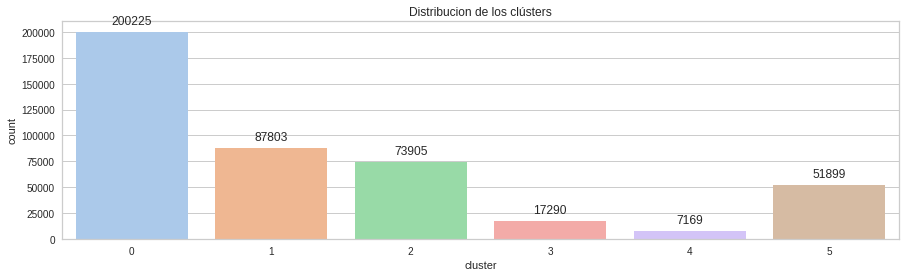

In [72]:
# distribución de los clientes en cada clúster
plt.subplots(figsize=(15, 4))
ax = sns.countplot(x=df_kmeans["cluster"], palette='pastel')
ax.set_title("Distribucion de los clústers")

add_value_labels(ax)
plt.show()

### describe de cada clúster

In [73]:
cluster0 = df_kmeans[df_kmeans['cluster']==0]
cluster1 = df_kmeans[df_kmeans['cluster']==1]
cluster2 = df_kmeans[df_kmeans['cluster']==2]
cluster3 = df_kmeans[df_kmeans['cluster']==3]
cluster4 = df_kmeans[df_kmeans['cluster']==4]
cluster5 = df_kmeans[df_kmeans['cluster']==5]

In [74]:
clusteres = [cluster0, cluster1, cluster2, cluster3, cluster4, cluster5]

In [75]:
cluster0.describe(include='all')

,entry_channel,active_customer,segment,gender,age,pension_plan,payroll_account,emc_account,debit_card,em_acount,alta_navidad,antiguedad,cluster,pk_cid,salary
count,200225,200225.000000,200225,200225,200225.000000,200225.000000,200225.000000,200225.000000,200225.000000,200225.000000,200225.000000,200225.000000,200225.0,2.002250e+05,1.632930e+05
unique,4,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,KHE,NaN,03 - UNIVERSITARIO,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,187263,NaN,195710,114931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.223249,NaN,NaN,24.527032,0.000340,0.010233,0.001693,0.023978,0.790925,0.490074,30.666385,0.0,1.191927e+06,1.156912e+05
std,NaN,0.416425,NaN,NaN,3.480592,0.018426,0.100642,0.041112,0.152981,0.406649,0.499903,10.125094,0.0,1.087752e+05,1.886699e+05
min,NaN,0.000000,NaN,NaN,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,8.426300e+04,1.202730e+03
25%,NaN,0.000000,NaN,NaN,22.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,20.000000,0.0,1.090394e+06,6.097410e+04
50%,NaN,0.000000,NaN,NaN,24.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,30.000000,0.0,1.187849e+06,8.807382e+04
75%,NaN,0.000000,NaN,NaN,26.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,42.000000,0.0,1.293129e+06,1.313066e+05


In [76]:
cluster1.describe(include='all')

,entry_channel,active_customer,segment,gender,age,pension_plan,payroll_account,emc_account,debit_card,em_acount,alta_navidad,antiguedad,cluster,pk_cid,salary
count,87803,87803.000000,87803,87803,87803.000000,87803.000000,87803.000000,87803.000000,87803.000000,87803.000000,87803.000000,87803.000000,87803.0,8.780300e+04,4.585800e+04
unique,4,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,otro,NaN,02 - PARTICULARES,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,55551,NaN,81243,50348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.622632,NaN,NaN,41.538843,0.000911,0.046445,0.101511,0.182215,0.606278,0.402344,14.846349,1.0,1.346653e+06,1.204188e+05
std,NaN,0.484731,NaN,NaN,13.942531,0.030171,0.210448,0.302006,0.386024,0.488577,0.490373,12.906623,0.0,2.178364e+05,3.110775e+05
min,NaN,0.000000,NaN,NaN,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.606300e+04,3.796860e+03
25%,NaN,0.000000,NaN,NaN,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.0,1.264615e+06,6.253139e+04
50%,NaN,1.000000,NaN,NaN,39.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,12.000000,1.0,1.391656e+06,9.049275e+04
75%,NaN,1.000000,NaN,NaN,49.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,20.000000,1.0,1.508658e+06,1.344104e+05


In [77]:
cluster2.describe(include='all')

,entry_channel,active_customer,segment,gender,age,pension_plan,payroll_account,emc_account,debit_card,em_acount,alta_navidad,antiguedad,cluster,pk_cid,salary
count,73905,73905.000000,73905,73905,73905.000000,73905.000000,73905.000000,73905.000000,73905.000000,73905.000000,73905.000000,73905.000000,73905.0,7.390500e+04,2.584600e+04
unique,3,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,KHQ,NaN,03 - UNIVERSITARIO,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,73758,NaN,72773,41998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.270956,NaN,NaN,22.108085,0.000365,0.003586,0.000474,0.014681,0.719356,0.455788,6.852459,2.0,1.459899e+06,1.106793e+05
std,NaN,0.444456,NaN,NaN,3.204533,0.019110,0.059774,0.021757,0.120273,0.449317,0.498045,1.706081,0.0,3.423971e+04,1.223123e+05
min,NaN,0.000000,NaN,NaN,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1.890540e+05,3.731790e+03
25%,NaN,0.000000,NaN,NaN,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.0,1.431858e+06,6.050607e+04
50%,NaN,0.000000,NaN,NaN,21.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.000000,2.0,1.461172e+06,8.657416e+04
75%,NaN,1.000000,NaN,NaN,23.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,8.000000,2.0,1.486106e+06,1.271566e+05


In [78]:
cluster3.describe(include='all')

,entry_channel,active_customer,segment,gender,age,pension_plan,payroll_account,emc_account,debit_card,em_acount,alta_navidad,antiguedad,cluster,pk_cid,salary
count,17290,17290.000000,17290,17290,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.0,1.729000e+04,1.258100e+04
unique,5,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,otro,NaN,02 - PARTICULARES,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7343,NaN,11994,9160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.998670,NaN,NaN,36.846964,0.955176,0.951128,0.225101,0.662984,0.064662,0.387796,23.857548,3.0,1.253528e+06,1.146676e+05
std,NaN,0.036449,NaN,NaN,11.531279,0.206922,0.215607,0.417661,0.472704,0.245935,0.487262,14.080427,0.0,1.927147e+05,1.180540e+05
min,NaN,0.000000,NaN,NaN,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,1.797000e+04,5.163750e+03
25%,NaN,1.000000,NaN,NaN,29.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,3.0,1.127426e+06,6.207834e+04
50%,NaN,1.000000,NaN,NaN,34.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,23.000000,3.0,1.254144e+06,8.988870e+04
75%,NaN,1.000000,NaN,NaN,42.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,35.000000,3.0,1.390444e+06,1.334520e+05


In [79]:
cluster4.describe(include='all')

,entry_channel,active_customer,segment,gender,age,pension_plan,payroll_account,emc_account,debit_card,em_acount,alta_navidad,antiguedad,cluster,pk_cid,salary
count,7169,7169.000000,7169,7169,7169.000000,7169.000000,7169.000000,7169.000000,7169.000000,7169.000000,7169.000000,7169.000000,7169.0,7.169000e+03,4.419000e+03
unique,5,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,otro,NaN,01 - TOP,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4248,NaN,7169,4172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.967917,NaN,NaN,53.934161,0.084949,0.109778,0.541498,0.137955,0.581253,0.358627,19.065421,4.0,1.265313e+06,1.478166e+05
std,NaN,0.176232,NaN,NaN,14.567772,0.278825,0.312635,0.498310,0.344877,0.493388,0.479631,14.656542,0.0,2.729691e+05,1.827253e+05
min,NaN,0.000000,NaN,NaN,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,1.620300e+04,1.429356e+04
25%,NaN,1.000000,NaN,NaN,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.0,1.128128e+06,8.256376e+04
50%,NaN,1.000000,NaN,NaN,52.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,15.000000,4.0,1.345435e+06,1.213133e+05
75%,NaN,1.000000,NaN,NaN,63.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,30.000000,4.0,1.449773e+06,1.792825e+05


In [80]:
cluster5.describe(include='all')

,entry_channel,active_customer,segment,gender,age,pension_plan,payroll_account,emc_account,debit_card,em_acount,alta_navidad,antiguedad,cluster,pk_cid,salary
count,51899,51899.000000,51899,51899,51899.000000,51899.000000,51899.000000,51899.000000,51899.000000,51899.000000,51899.000000,51899.000000,51899.0,5.189900e+04,4.134800e+04
unique,2,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,KFC,NaN,02 - PARTICULARES,V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,51896,NaN,48006,31776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.508757,NaN,NaN,39.731305,0.000559,0.055435,0.147537,0.170639,0.476079,0.323629,31.547756,5.0,1.172060e+06,1.158821e+05
std,NaN,0.499928,NaN,NaN,12.981440,0.023632,0.228829,0.354643,0.376197,0.499432,0.467865,10.842395,0.0,1.321271e+05,1.992945e+05
min,NaN,0.000000,NaN,NaN,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.0,3.370600e+04,6.480660e+03
25%,NaN,0.000000,NaN,NaN,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,5.0,1.095588e+06,6.177733e+04
50%,NaN,1.000000,NaN,NaN,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,5.0,1.191603e+06,8.844717e+04
75%,NaN,1.000000,NaN,NaN,46.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,41.000000,5.0,1.257448e+06,1.304866e+05


### genero

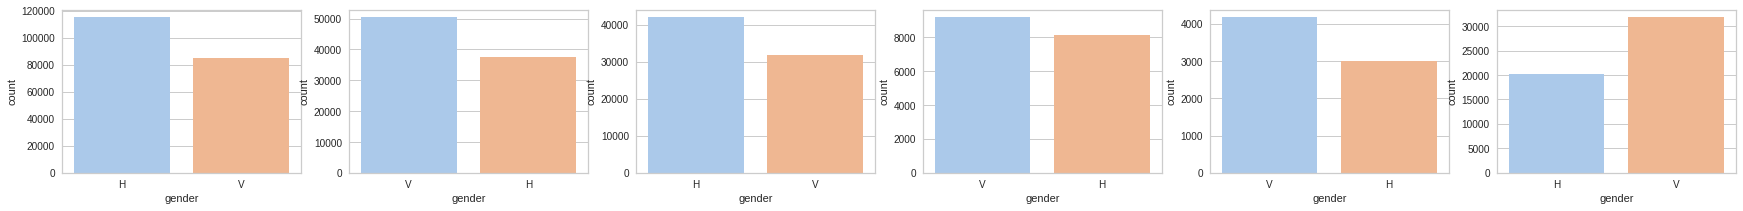

In [81]:
# Detalles de genero

fig, ax = plt.subplots(1, 6, sharey=False, figsize=(30, 3))
for i, cluster in enumerate(clusteres):
    sns.countplot(data=cluster, x='gender', ax=ax[i], palette='pastel')
plt.show()

### age

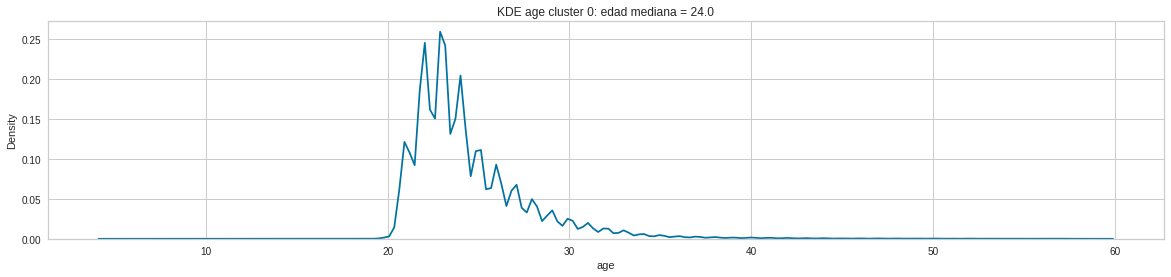

****************************************************************************************************************************************************************


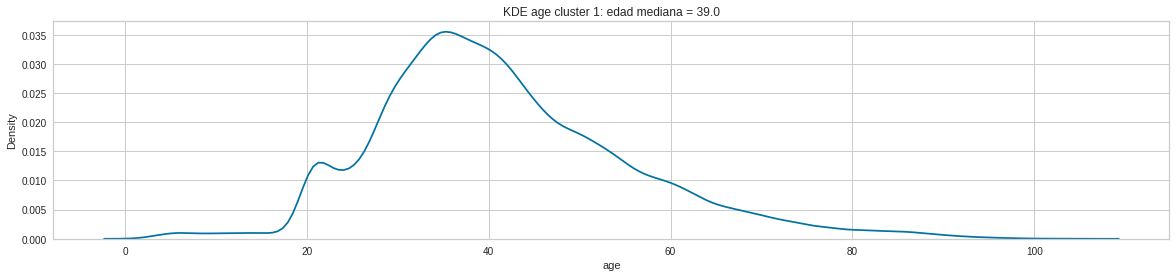

****************************************************************************************************************************************************************


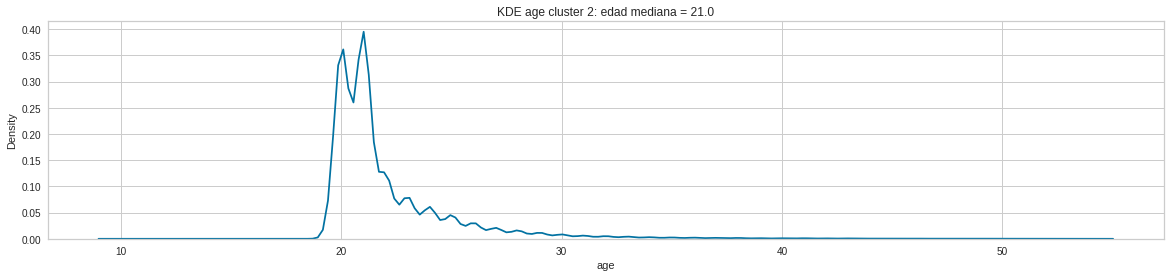

****************************************************************************************************************************************************************


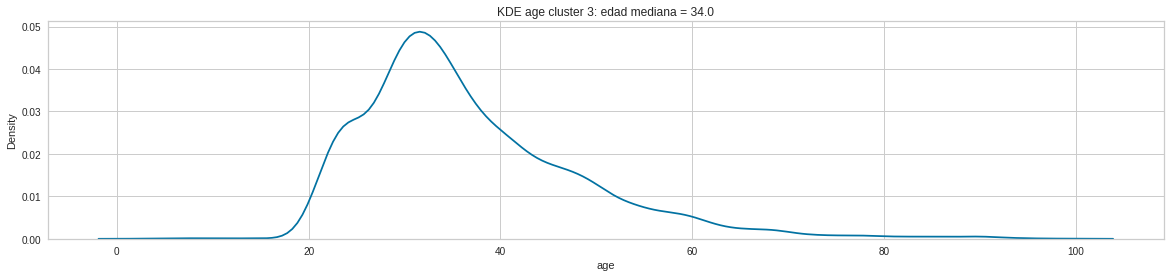

****************************************************************************************************************************************************************


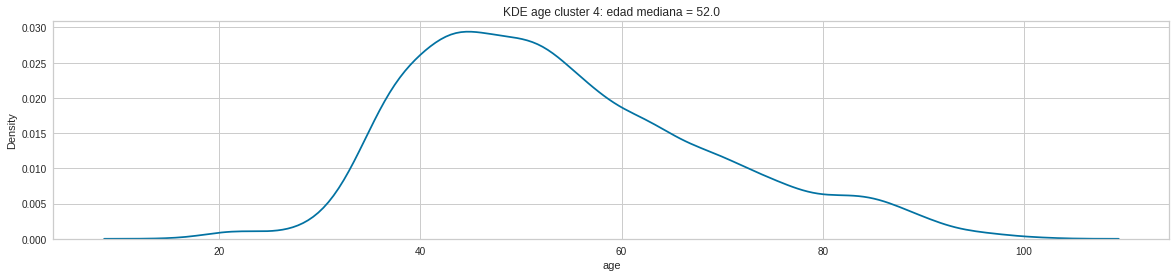

****************************************************************************************************************************************************************


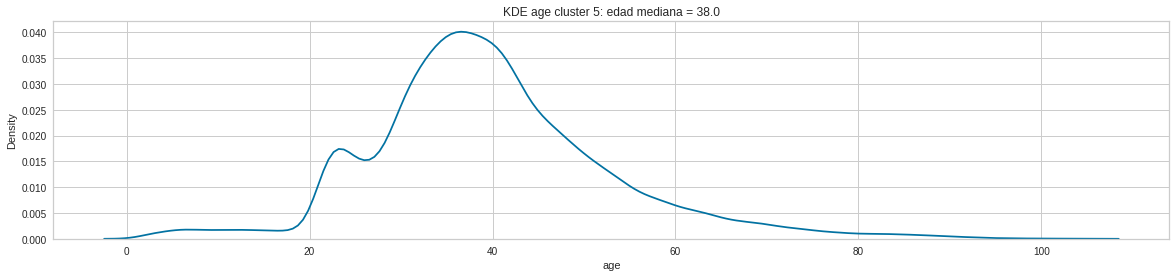

****************************************************************************************************************************************************************


In [82]:
# Detalles de age
for i, cluster in enumerate(clusteres):
  plt.figure(figsize=(20,4))
  pl = sns.kdeplot(data=cluster, x='age', palette='pastel')
  pl.set_title("KDE age cluster {}: edad mediana = {}".format(i, round(cluster['age'].median(), 1)))
  plt.show()
  print('*'*160)

### alta_navidad

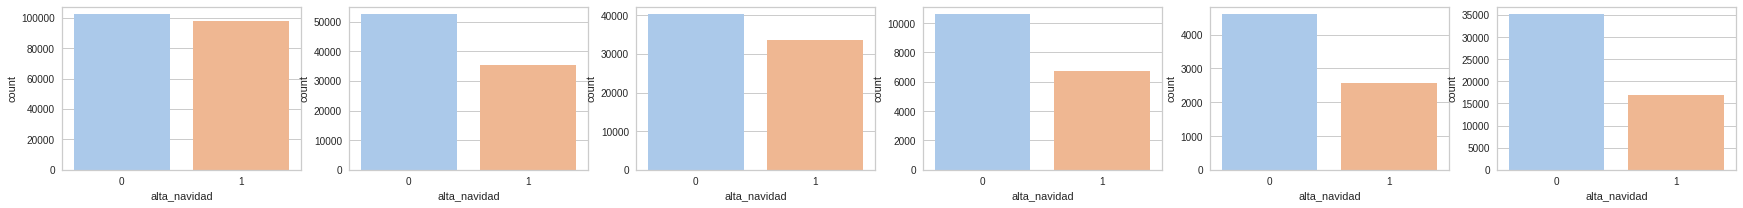

In [83]:
# Detalles de alta_navidad

fig, ax = plt.subplots(1, 6, sharey=False, figsize=(30, 3))
for i, cluster in enumerate(clusteres):
    sns.countplot(data=cluster, x='alta_navidad', ax=ax[i], palette='pastel')
plt.show()

### antigüedad

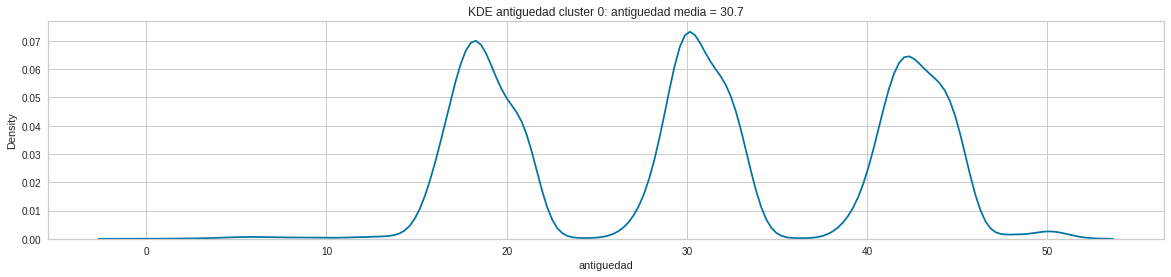

****************************************************************************************************************************************************************


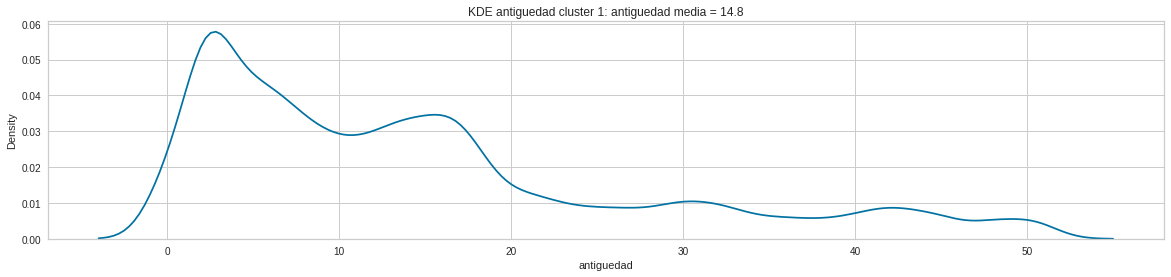

****************************************************************************************************************************************************************


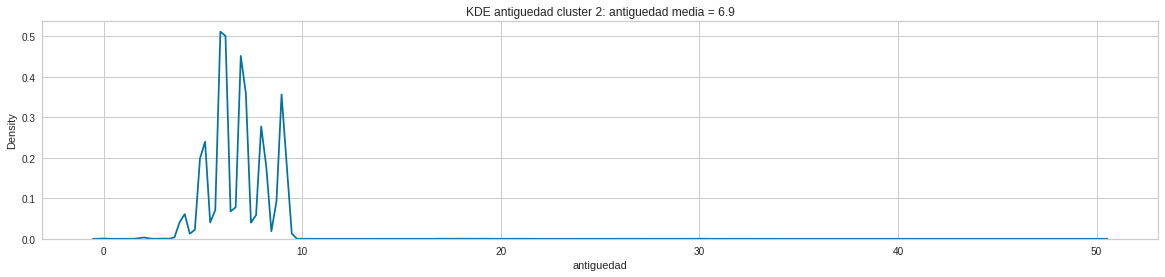

****************************************************************************************************************************************************************


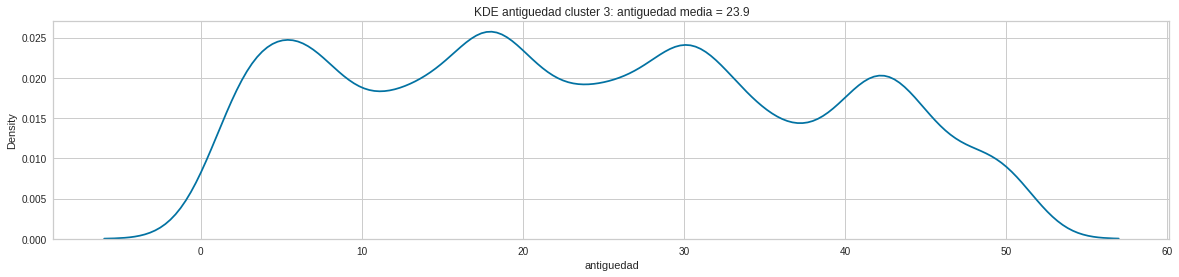

****************************************************************************************************************************************************************


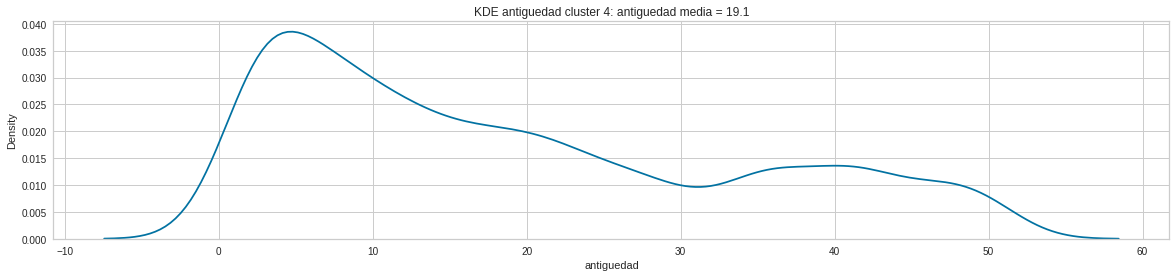

****************************************************************************************************************************************************************


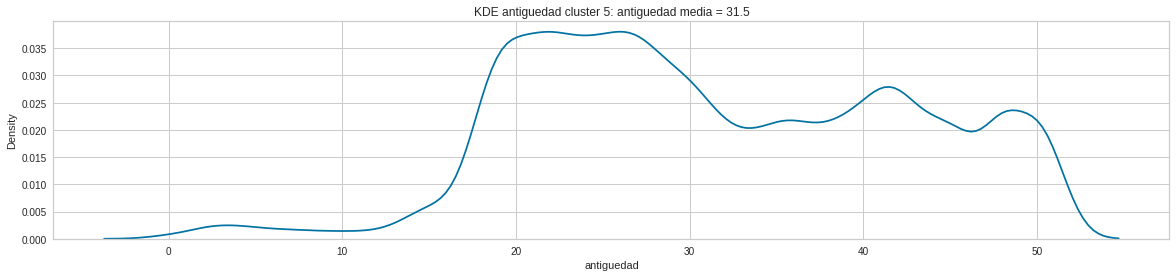

****************************************************************************************************************************************************************


In [84]:
# Detalles de antiguedad
for i, cluster in enumerate(clusteres):
  plt.figure(figsize=(20,4))
  pl = sns.kdeplot(data=cluster, x='antiguedad', palette='pastel')
  pl.set_title("KDE antiguedad cluster {}: antiguedad media = {}".format(i, round(cluster['antiguedad'].mean(), 1)))
  plt.show()
  print('*'*160)

### active_customer

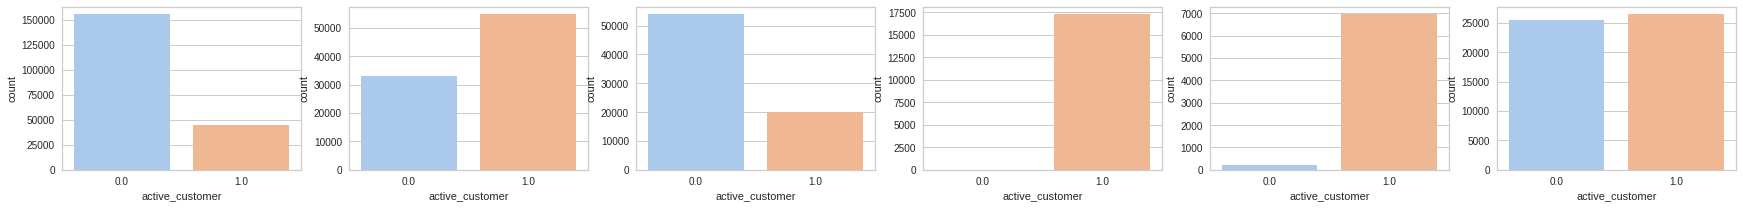

In [85]:
# Detalles de active_customer

fig, ax = plt.subplots(1, 6, sharey=False, figsize=(30, 3))
for i, cluster in enumerate(clusteres):
    sns.countplot(data=cluster, x='active_customer', ax=ax[i], palette='pastel')
plt.show()

### segmento

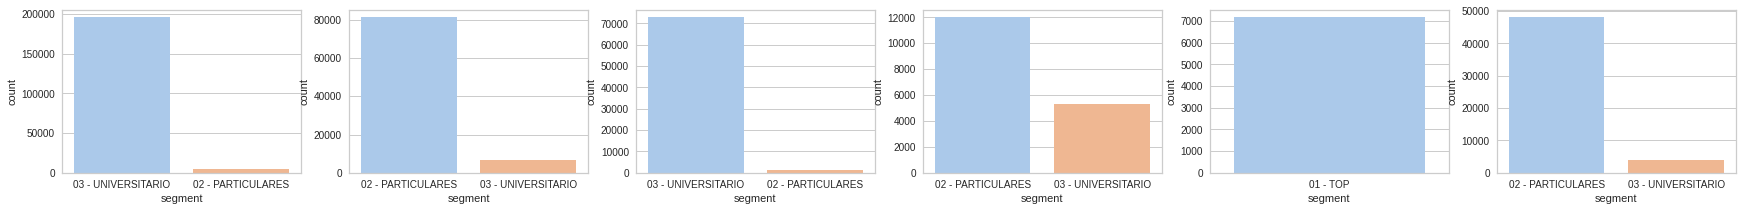

In [86]:
# Detalles de segmento

fig, ax = plt.subplots(1, 6, sharey=False, figsize=(30, 3))
for i, cluster in enumerate(clusteres):
    sns.countplot(data=cluster, x='segment', ax=ax[i], palette='pastel')
plt.show()

### entry_channel

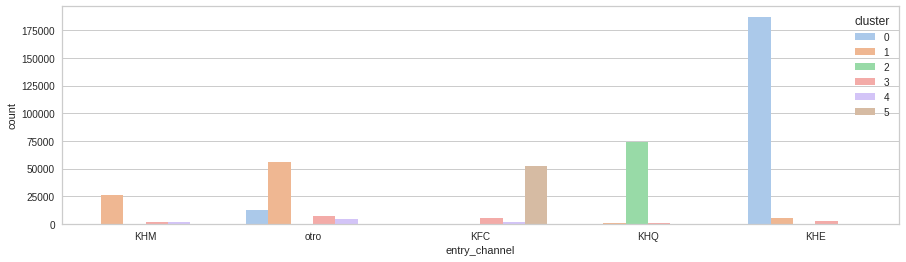

In [87]:
plt.figure(figsize=(15,4))
pl = sns.countplot(data=df_kmeans, x='entry_channel', hue='cluster', palette='pastel')
plt.show()

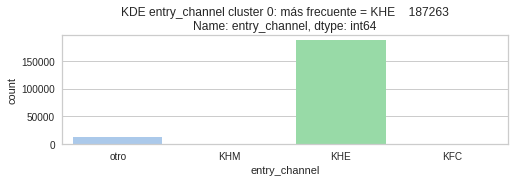

****************************************************************************************************************************************************************


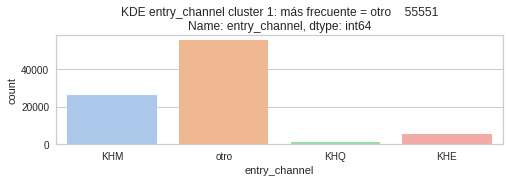

****************************************************************************************************************************************************************


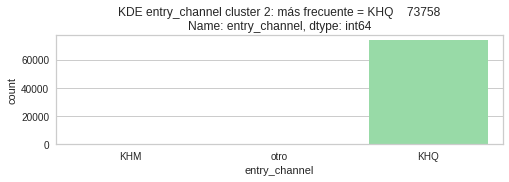

****************************************************************************************************************************************************************


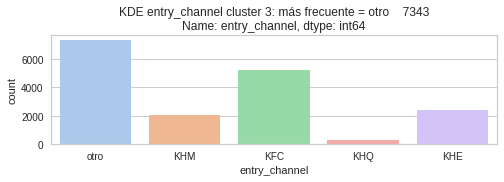

****************************************************************************************************************************************************************


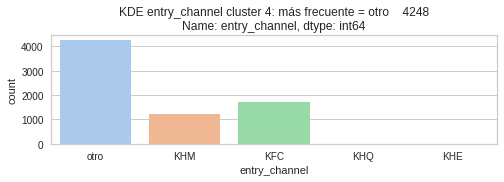

****************************************************************************************************************************************************************


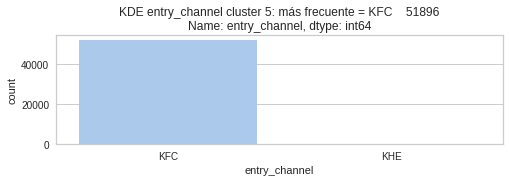

****************************************************************************************************************************************************************


In [88]:
# Detalles de entry_channel
for i, cluster in enumerate(clusteres):
  plt.figure(figsize=(8,2))
  pl = sns.countplot(data=cluster, x='entry_channel', palette='pastel')
  pl.set_title("KDE entry_channel cluster {}: más frecuente = {}".format(i, cluster['entry_channel'].value_counts().head(1)))
  plt.show()
  print('*'*160)

### easyMoney

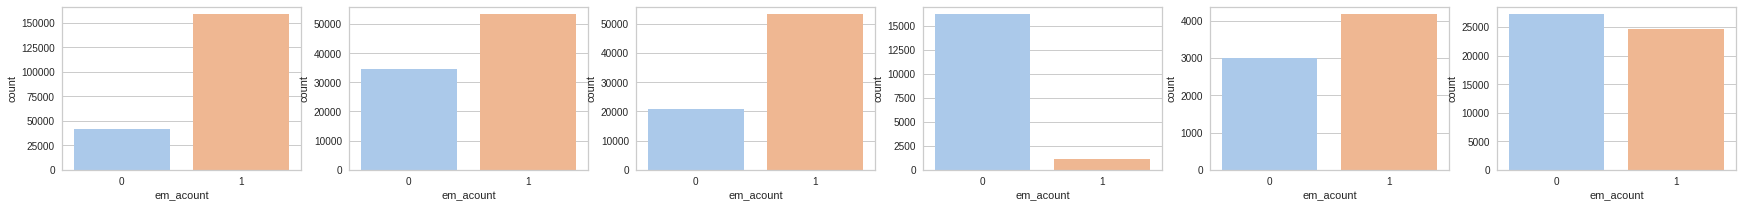

In [89]:
# Detalles de easyMoney

fig, ax = plt.subplots(1, 6, sharey=False, figsize=(30, 3))
for i, cluster in enumerate(clusteres):
    sns.countplot(data=cluster, x='em_acount', ax=ax[i], palette='pastel')
plt.show()

### plan de pensión

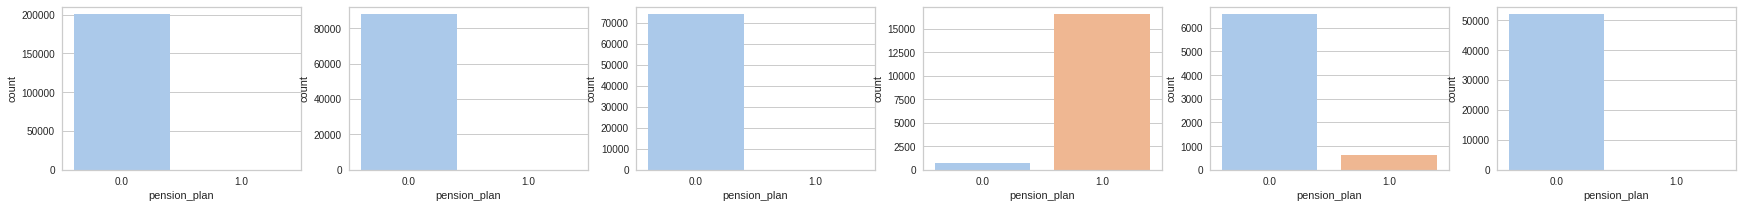

In [90]:
# Detalles deplan de pensión

fig, ax = plt.subplots(1, 6, sharey=False, figsize=(30, 3))
for i, cluster in enumerate(clusteres):
    sns.countplot(data=cluster, x='pension_plan', ax=ax[i], palette='pastel')
plt.show()

### easy crypto

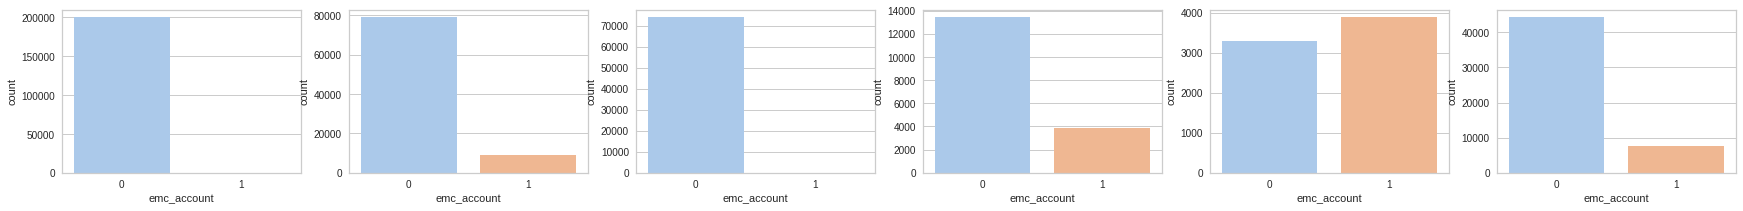

In [91]:
# Detalles de easy crypto

fig, ax = plt.subplots(1, 6, sharey=False, figsize=(30, 3))
for i, cluster in enumerate(clusteres):
    sns.countplot(data=cluster, x='emc_account', ax=ax[i], palette='pastel')
plt.show()

### cuenta bonificada

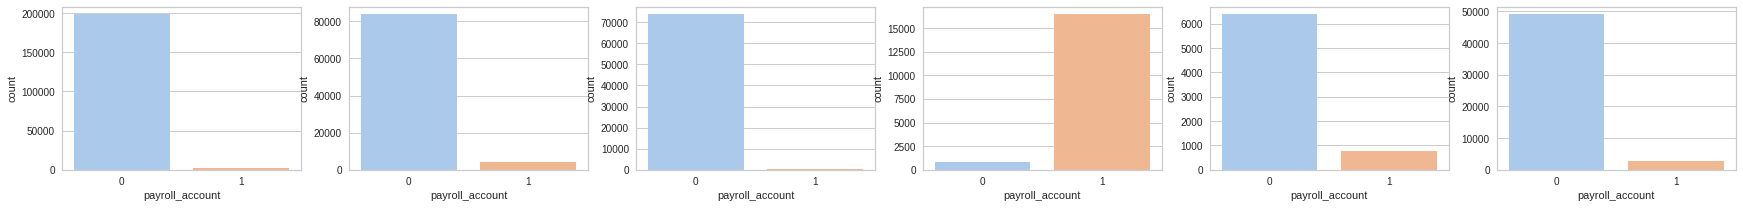

In [92]:
# Detalles de cuenta bonificada

fig, ax = plt.subplots(1, 6, sharey=False, figsize=(30, 3))
for i, cluster in enumerate(clusteres):
    sns.countplot(data=cluster, x='payroll_account', ax=ax[i], palette='pastel')
plt.show()

### debit_card

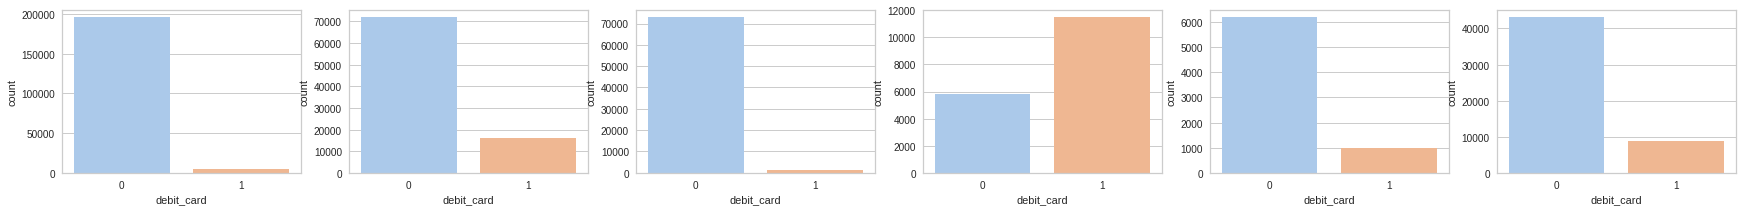

In [93]:
# Detalles de debit_card

fig, ax = plt.subplots(1, 6, sharey=False, figsize=(30, 3))
for i, cluster in enumerate(clusteres):
    sns.countplot(data=cluster, x='debit_card', ax=ax[i], palette='pastel')
plt.show()

### salario

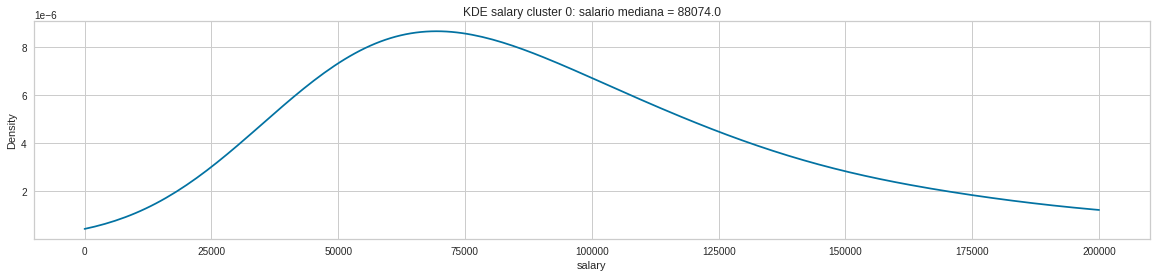

****************************************************************************************************************************************************************


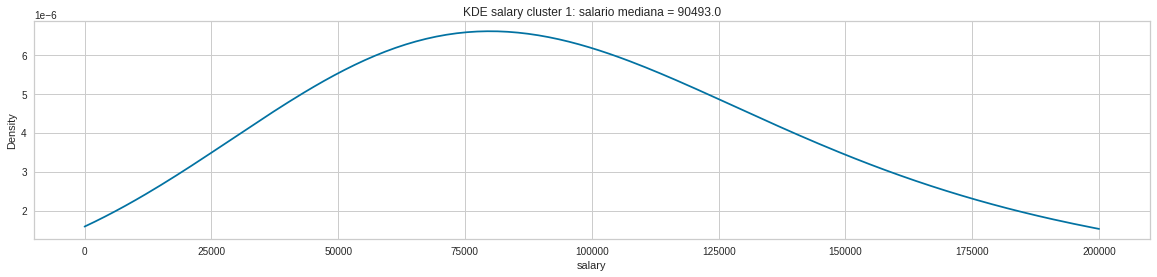

****************************************************************************************************************************************************************


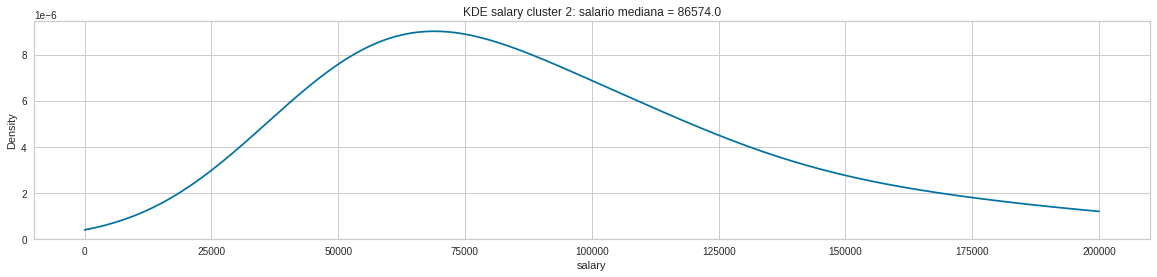

****************************************************************************************************************************************************************


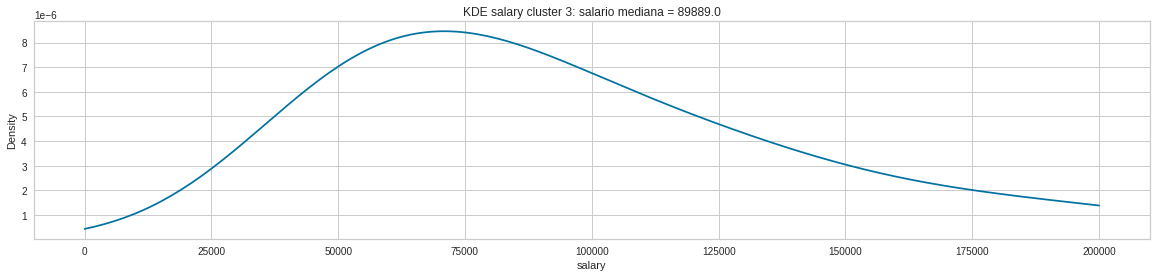

****************************************************************************************************************************************************************


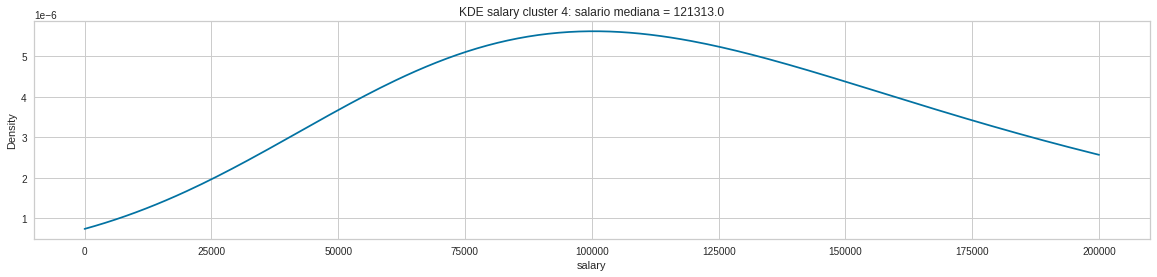

****************************************************************************************************************************************************************


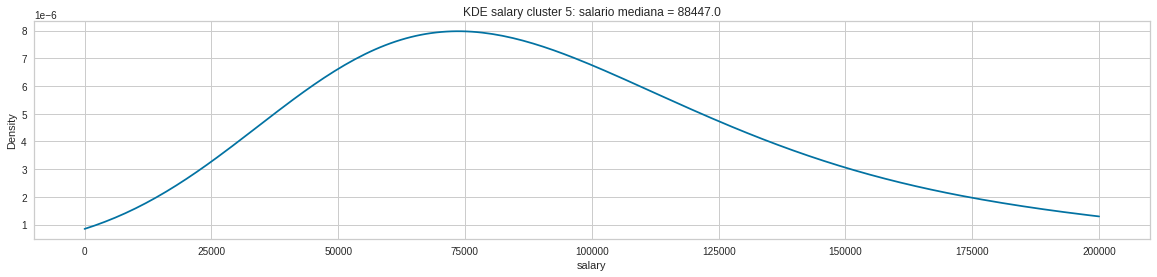

****************************************************************************************************************************************************************


In [94]:
# Detalles de salario
for i, cluster in enumerate(clusteres):
  plt.figure(figsize=(20,4))
  pl = sns.kdeplot(data=cluster, x='salary', palette='pastel', clip=(0.0, 200000))
  pl.set_title("KDE salary cluster {}: salario mediana = {}".format(i, round(cluster['salary'].median(), 0)))
  plt.show()
  print('*'*160)

## perfilado detallado

- **clúster 0 (200.000 clientes): joven universitaria. Compraba en Navidad la cuenta easyMoney con el canal KHE**
  - es más proclive a ser mujer
  - tiene entre 22 y 26 años
  - salario mediano muy parecido al resto: 88.000€
  - cliente que se da de alta principalmente en navidad
  - cliente con una antigüedad de más de 18 meses: no fidelizamos más este 
perfil
  - no es un cliente muy activo
  - es universitario
  - canal de entrada KHE
  - cliente de easyMoney
- **clúster 1 (88.000 clientes): hombre particular de edad media en plena expansión, cliente de easyMoney, algo de crypto y debit_card, activo**
  - es más proclive a ser hombre
  - tiene entre 32 y 49 años, con más probabilidad 38
  - salario mediano muy parecido al resto: 90.000€
  - tiene una antigüedad menor de 18 meses. Es un perfil en plena expansión
  - principalemente es un cliente activo
  - es particular
  - canal de entrada otros y un poco KHM
  - bastante cliente de easyMoney
  - tiene un poco de crypto y debit card
- **clúster 2 (74.000 clientes): mujer muy joven universitaria que compró en las últimas navidades la cuenta easyMoney con el canal KHQ**
  - es más proclive a ser mujer
  - tiene entre 20 y 23 años
  - salario mediano muy parecido al resto:86.000€
  - cliente que se da de alta principalmente en navidad
  - perfil con una antigüedad menor de 9 meses. Se dió de alta para las últimas navidades
  - no es un cliente muy activo
  - es universitario
  - canal de entrada KHQ
  - cliente de easyMoney
- **clúster 3 (17.000 clientes): particular treinta añero activo sin easyMoney pero con plan de pensión, cuenta bonificada, debit_card y algo de crypto. Cliente valor seguro**
  - es un poco más proclive a ser hombre
  - tiene entre 29 y 42 años, con más probabilidad 33
  - salario mediano muy parecido al resto:90.000€
  - antigüedad regular: fidelizamos este perfil de manera constante, algo más en periodos navideños
  - cliente totalmente activo
  - es particular
  - canal de entrada repartidos: otros, KFC, KHE, KHM
  - no es cliente de easyMoney 
  - cliente de plan de pensión
  - tiene un poco de crypto
  - cliente de cuenta bonificada
  - cliente principal de debit card
- **clúster 4 (7.000 clientes): cliente TOP, alto poder adquisitivo, mayor, activo, cliente principal de crypto, tiene bastante easyMoney y algo de plan de pensión, cuenta bonificada y debit_card. Cliente en plena expansión.**
  - es bastante más proclive a ser hombre
  - tiene entre 43 y 63 años, con más probabilidad 43
  - salario mediano muy superior al resto: 121.000€ (más de 30.000€ sobre el resto)
  - perfil con una antigüedad con vez menor: perfil en plena expansión
  - cliente casí totalmente activo
  - es el cliente top
  - canal de entrada repartidos: principalmente otros y también KFC y KHM
  - bastante cliente de easyMoney
  - tiene un poco de plan de pensión
  - cliente principal de crypto
  - tiene un poco de cuenta bonificada y debit card
- **clúster 5 (52.000 clientes): particular edad media, mitad activo, canal KFC, mitad easymoney. No fidelizamos más este perfil desde hace 18 meses.**
  - es bastante más proclive a ser hombre
  - tiene entre 32 y 46 años, con más probabilidad 38
  - salario mediano muy parecido al resto:88.000€
  - tiene una antigüedad mayor de 18 meses. No fidelizamos más este perfil
  - mitad activo, mitad no activo
  - es particular
  - canal de entrada KFC
  - mitad cliente easyMoney, mitad no
  - tiene un poco de crypto y debit card

# resumen del perfilado
# la clientela se puede segmentar de la siguiente forma:

* **UNIVERSITARIO:**
  entre 22 y 24 años,
  no activo,
  navideño,
  cliente cuenta easyMoney
 <br>-> canal de entrada KHQ: nuevo cliente
 <br>-> canal de entrada KHE: antiguos cliente
* **PARTICULAR:**
entre 30 y 45 años,
salario de 90 K€,
<br>-> totalmente activo: cliente plan de pensión
<br>-> poco activo: cliente todos productos menos plan de pensión
<br>----> canal de entrada KHM u otros: nuevo cliente
<br>----> canal de entrada KFC: antiguo cliente
* **TOP:**</br>
entre 40 y 60 años,
120 K€ de salario,
totalmente activo,
cliente de crypto y cuenta easyMoney


# **conclusiones**

**recomendaciones para las acciones de marketing de captación:**
- campaña navideña para el universitario sobre el producto easyMoney con el canal de entrada KHQ
- campaña para el particular de 29 a 42 años de menos de 100.000€ sobre el plan de pensión
- campaña para el particular de 32 a 49 años de menos de 100.000€ sobre la cuenta easyMoney con el canal de entrada KHM
- campaña  para el particular de 40 a 60 años de más de 100.000€ sobre la crypto